# Train the model and get preliminary data
This code is a adapted copy of "[Basic tutorial for query to reference mapping using expiMap](https://docs.scarches.org/en/latest/expimap_surgery_pipeline_basic.html)" with some minor modifications so that the script can work with a different data set.

# Block 1: Data preparation(downloading)
The script initializes libraries and configures for scanpy.  

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
import os

 captum (see https://github.com/pytorch/captum).


In [2]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

Reminder, you can change the path.

In [3]:
if not os.path.exists("tyser.h5ad"):
    url = 'https://drive.google.com/uc?id=1mJ8nYnDQdDUivZpAFIPoNPMppOUCRAPT'
    output = 'tyser.h5ad'
    gdown.download(url, output, quiet=False)

In [4]:
adata = sc.read('tyser.h5ad')

In [5]:
if not os.path.exists("hiPSC.h5ad"):
    url = 'https://drive.google.com/uc?id=1JGatjjXPXKZza5ksOWYHD2kJvUSDZG-0'
    output = 'hiPSC.h5ad'
    gdown.download(url, output, quiet=False)

In [6]:
hips =  sc.read("hiPSC.h5ad")

## Snapshot of data structure of Tyser:
![](Tyser.svg)

In [7]:
adata

AnnData object with n_obs × n_vars = 1069 × 57490
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'
    var: 'features'

In [8]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt
SS.sc7786612,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482
SS.sc7786605,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160
SS.sc7785737,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179
SS.sc7785398,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720
SS.sc7788091,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS.sc7785965,0,226569.027995,6361,SS.sc7785965,caudal,epiblast cell,epiblast cell,Epiblast,Epiblast,tyser,tyser,tyser,tyser,1.675409
SS.sc7788259,0,353921.980998,4647,SS.sc7788259,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.615045
SS.sc7786123,0,366998.009999,2822,SS.sc7786123,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.602395
SS.sc7786212,0,459601.642974,6110,SS.sc7786212,caudal,epiblast cell,epiblast cell,Epiblast,Epiblast,tyser,tyser,tyser,tyser,1.150624


In [9]:
adata.var

,features
A1BG,A1BG
A1BG.AS1,A1BG.AS1
A1CF,A1CF
A2M,A2M
A2M.AS1,A2M.AS1
...,...
ZYG11B,ZYG11B
ZYX,ZYX
ZYXP1,ZYXP1
ZZEF1,ZZEF1


## Snapshot of data structure of hiPSC-file:
![](hiPSC.svg)

In [10]:
hips

AnnData object with n_obs × n_vars = 4694 × 23543
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_mnn', 'X_umap'
    obsp: 'distances'

In [11]:
hips.obs

,orig.ident,nCount_RNA,nFeature_RNA,run,sample_name,percent.mt,percent.dissoc,RNA_snn_res.0.3,seurat_clusters,RNA_snn_res.0.22
batch_2_A_AAACCCAAGGTAATCA-1,SeuratProject,48806.0,6892,0h_A,iPSC_99_4,5.110027,0.013308,2,0,0
batch_2_A_AAAGGATCATCCAATG-1,SeuratProject,5460.0,2307,0h_A,iPSC_99_4,0.201465,0.015073,7,0,0
batch_2_A_AAAGGATGTGGTCAAG-1,SeuratProject,32899.0,5707,0h_A,iPSC_99_4,4.097389,0.014101,2,0,0
batch_2_A_AAAGGTAGTGTCATCA-1,SeuratProject,37327.0,6069,0h_A,iPSC_99_4,4.532912,0.013420,2,0,0
batch_2_A_AAATGGACATATCTGG-1,SeuratProject,18633.0,4701,0h_A,iPSC_99_4,4.932110,0.013176,2,0,0
...,...,...,...,...,...,...,...,...,...,...
batch_1_sample_120H_TTTACTGCATCCGCGA-1,SeuratProject,14013.0,4629,120h,iPSC_72_1,4.767002,0.017398,3,2,2
batch_1_sample_120H_TTTCACATCAGCCCAG-1,SeuratProject,21173.0,5140,120h,iPSC_72_1,4.127899,0.014142,5,4,4
batch_1_sample_120H_TTTCAGTAGTACAGAT-1,SeuratProject,22107.0,5437,120h,iPSC_72_1,2.035554,0.013721,3,2,2
batch_1_sample_120H_TTTGATCAGCTCCATA-1,SeuratProject,12806.0,4127,120h,iPSC_72_1,3.428081,0.015297,3,2,2


In [12]:
hips.var

,features
AL627309.1,AL627309.1
AL627309.5,AL627309.5
LINC01409,LINC01409
LINC01128,LINC01128
LINC00115,LINC00115
...,...
AC234781.1,AC234781.1
ZFY-AS1,ZFY-AS1
AC012078.2,AC012078.2
AC011751.1,AC011751.1


In [13]:
hips.uns

{'neighbors': {'params': {'method': array(['snn'], dtype=object),
   'n_neighbors': array([20.])}}}

The `hips.obsm["X_mnn"]` is a array, so we print first 2 values

In [14]:
hips.obsm["X_mnn"][0:2]


array([[-1.77e-01,  3.65e-02, -3.90e-03,  2.58e-02,  6.98e-02, -1.08e-02,
         8.35e-03,  2.22e-02,  6.62e-02,  1.35e-02, -5.58e-02, -1.78e-02,
        -5.88e-03,  1.23e-02, -1.34e-02,  2.97e-02,  1.74e-03, -6.59e-03,
        -2.10e-02, -2.54e-03, -3.39e-02, -4.23e-04,  4.83e-03,  2.59e-02,
        -2.22e-02,  1.50e-02,  1.37e-03,  2.31e-03,  1.32e-02,  2.49e-02,
         1.18e-03,  4.32e-03, -3.55e-02, -8.75e-03,  1.73e-03, -1.02e-02,
         1.64e-02, -2.70e-02,  4.62e-03, -2.54e-05, -2.60e-02, -3.70e-03,
         5.52e-03,  3.02e-02,  1.28e-02, -6.18e-03, -1.31e-03, -5.43e-04,
        -3.41e-03, -2.32e-02],
       [-1.08e-01,  1.10e-02,  1.99e-02,  1.48e-01, -8.52e-02, -7.54e-02,
         2.11e-02,  2.53e-02, -4.00e-03,  1.74e-02, -7.06e-02, -8.19e-03,
        -7.58e-02, -8.75e-02,  5.59e-02,  2.21e-02, -2.09e-02, -3.36e-02,
         1.80e-02,  3.99e-02,  5.86e-02, -9.52e-02,  1.02e-01, -6.83e-02,
         6.56e-02,  4.24e-02, -3.40e-02,  3.32e-03,  9.66e-03,  1.53e-02,
       

The `hips.obsm["X_umap"]` is a array, so we print first 2 values

In [15]:
hips.obsm["X_umap"][0:2]

array([[ 0.82, -2.17],
       [ 2.15,  2.1 ]])

In [16]:
hips.obsp["distances"][:10,:10].toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

# Block 1 Data annotation 

In [17]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/luna/Desktop/in-house/scripts/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 10.8MB/s]


'reactome.gmt'

It reads the Reactome annotations, creates a binary matrix where rows represent gene symbols and columns represent terms, and adds the annotations matrix to the reference dataset. The binary matrix of annotations is stored in `adata.varm['I']`. Note that only terms with a minimum of 12 genes in the reference dataset are retained.

In [18]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

# All genes not present in the Reactome annotations are removed.
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    batch_key="sample_name",
    subset=True)

Filter out all annotations (terms) with fewer than 12 genes.

In [19]:
select_terms = adata.varm['I'].sum(0) > 12

adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

# Block 2: Data cutting

The initial logic of the script, as we understand it, involves applying transformations to the `X` matrix to identify more significant expression of individual genes.  
However, as a result of these transformations, the original imperative data represented by integers is converted into floating-point numbers. This necessitates a return to the original values stored in the `raw.X` layer.

This creates a problem: the `raw.X` matrix has the original dimensions 1069 × 57490 (where 1069 is the number of cells and 57490 is the number of genes), while the `X` matrix after filtering and selecting ~2000 genes has dimensions 1069 x K.  
Thus, the dimensions of the `raw.X` and `X` matrices do not match, making it impossible to directly use data from `raw.X` to restore the original values in `X` without a workaround.

In short, this is illustrated in the following figure.

![](Scissors_Script_Concept.svg)

In [20]:
# Step 1: Get the list of genes from var
var_genes = adata.var.index.tolist()

# Step 2: Find the corresponding column with gene names in raw.var
# Assume the column is named '_index'
if '_index' not in adata.raw.var.columns:
    raise ValueError("The column with gene names (e.g., '_index') is missing in raw.var")

raw_gene_names = adata.raw.var['_index'].tolist()

# Step 3: Find the indices of genes from var in raw.var
selected_raw_indices = [i for i, gene in enumerate(raw_gene_names) if gene in var_genes]

# Step 4: Extract data from raw.X for the selected genes
raw_X = adata.raw.X
if isinstance(raw_X, np.ndarray):  # If raw.X is in numpy array format
    filtered_raw_X = raw_X[:, selected_raw_indices]
else:  # If raw.X is a sparse matrix
    filtered_raw_X = raw_X[:, selected_raw_indices].toarray()

# Step 5: Replace X with data from raw.X
adata.X = filtered_raw_X

# Step 6: Update var to match the data
filtered_var = adata.raw.var.iloc[selected_raw_indices]
filtered_var.index = var_genes  # Assign the original var index
adata.var = filtered_var


In [21]:
hips.X = hips.raw.X

Cutting down the the genes, that doesn't have interconnection. 

In [22]:
commom = adata.var_names.intersection(hips.var_names)
hips = hips[:, commom].copy()
adata = adata[:, commom].copy()

# Block 3: Model Training on Tyser

In [25]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='sample_name',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 860 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 10
Decoder Architecture:
	First Layer in, out and cond:  10 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Output Layer in/out:  256 860 



In [26]:
ALPHA = 0.7

adata.X = adata.X.astype(np.float32)

In [27]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 860)
Instantiating dataset
 |████----------------| 22.5%  - epoch_loss: 1250.0821838379 - epoch_recon_loss: 1240.1854095459 - epoch_kl_loss: 22.2399835587 - epoch_mmd_loss: 0.0000000000 - val_loss: 1582.4017333984 - val_recon_loss: 1572.5526123047 - val_kl_loss: 22.1327762604 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |█████---------------| 25.8%  - epoch_loss: 1245.1704101562 - epoch_recon_loss: 1234.0906372070 - epoch_kl_loss: 22.1595454216 - epoch_mmd_loss: 0.0000000000 - val_loss: 1582.1063232422 - val_recon_loss: 1571.1091308594 - val_kl_loss: 21.9942874908 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |█████---------------| 29.0%  - epoch_loss: 1226.8308105469 - epoch_recon_loss: 1215.8728637695 - epoch_kl_loss: 21.9159481525 - epoch_mmd_loss: 0.0000000000 - val_loss: 1585.9652099609 - val_recon_loss: 1574.9976806641 - val_kl_loss: 21.9349384308 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 31.8%  - epoch_loss: 1223.5948944092 - epoch_recon_loss: 12

In [29]:
MEAN = False
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)


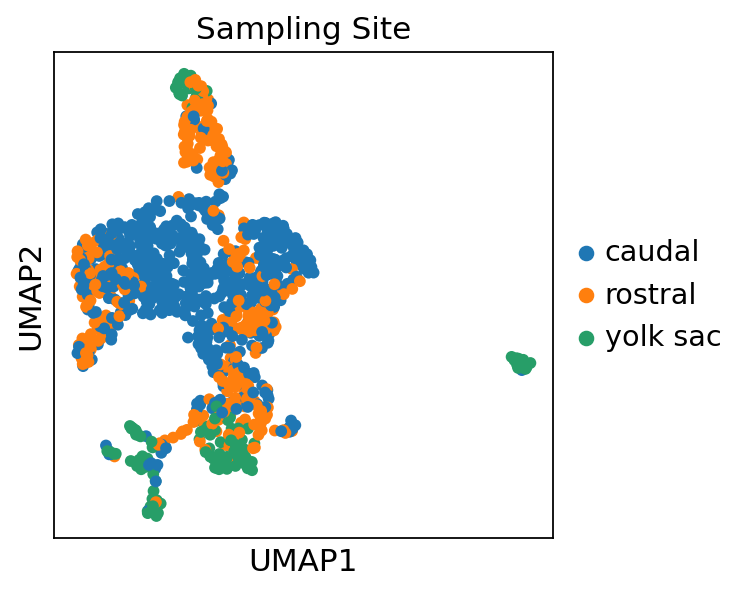

In [30]:
sc.pl.umap(adata,color=['Characteristics.sampling.site.'],title=["Sampling Site"], frameon=True)

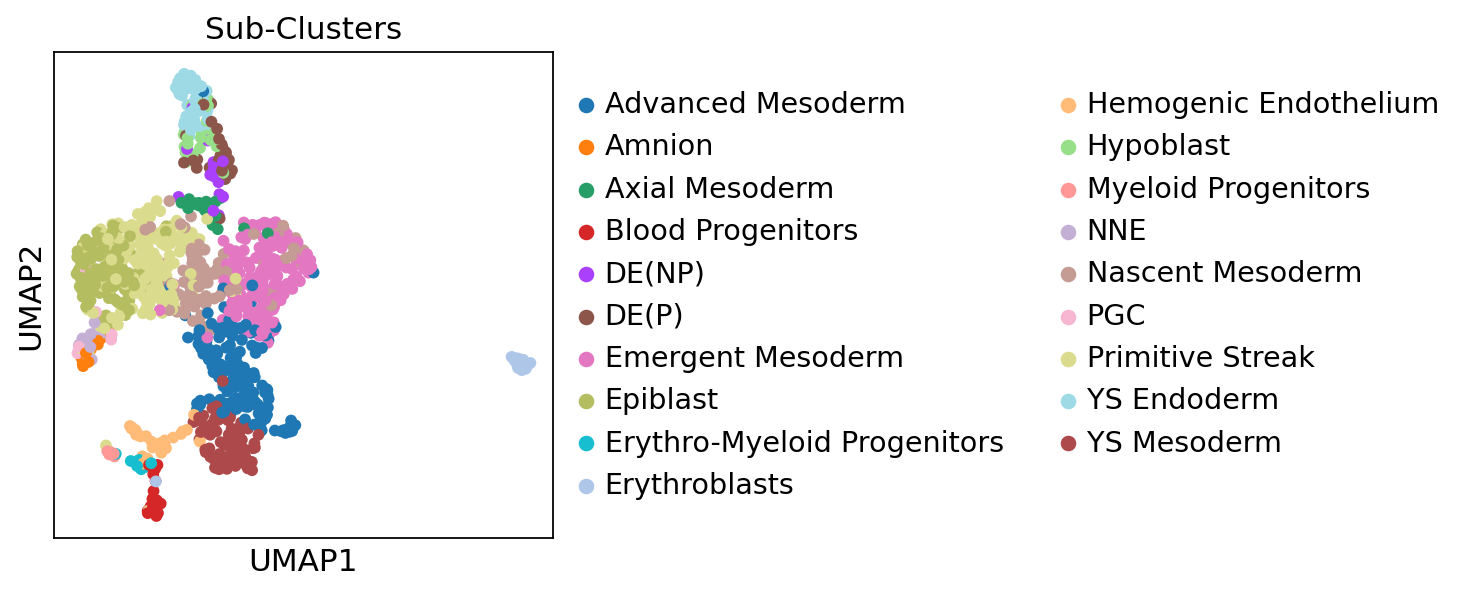

In [31]:
sc.pl.umap(adata,color=['sub_cluster'], title=["Sub-Clusters"],frameon=True)


# Block 3: Model Training on hiPSC

In [32]:
hips.X = hips.X.astype(np.float32)

hips.obs = hips.obs.rename(columns={"sample_id":"sample_name"})

In [33]:
hips.uns['terms'] = adata.uns['terms']

In [34]:
q_intr_cvae = sca.models.TRVAE.load_query_data(hips, intr_cvae)

q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


AnnData object with n_obs × n_vars = 4694 × 860
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22'
    var: 'features'
    uns: 'neighbors', 'terms'
    obsm: 'X_mnn', 'X_umap'
    obsp: 'distances'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 860 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 10
Decoder Architecture:
	First Layer in, out and cond:  10 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Output Layer in/out:  256 860 

Preparing (4694, 860)
Instantiating dataset
 |████████------------| 42.2%  - val_loss: 506.8097000122 - val_recon_loss: 498.8723602295 - val_kl_loss: 23.0031533241 - val_mmd_loss: 5.6370191574
ADJUSTED LR
 |████████------------| 44.0%  - val_loss: 507.3639068604 - val_recon_loss: 499.0719146729 - val_kl_loss: 22.9946384430 - val

In [36]:
dataset_samen = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')

dataset_samen.X = dataset_samen.X.astype(np.float32)

dataset_samen.obsm['X_cvae'] = q_intr_cvae.get_latent(dataset_samen.X, dataset_samen.obs['sample_name'], mean=MEAN)
sc.pp.neighbors(dataset_samen, use_rep='X_cvae')
sc.tl.umap(dataset_samen)

dataset_samen

AnnData object with n_obs × n_vars = 5763 × 860
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch_join'
    var: '_index-0', 'features-1'
    uns: 'terms', 'neighbors', 'umap'
    obsm: 'X_umap', 'X_cvae'
    obsp: 'distances', 'connectivities'

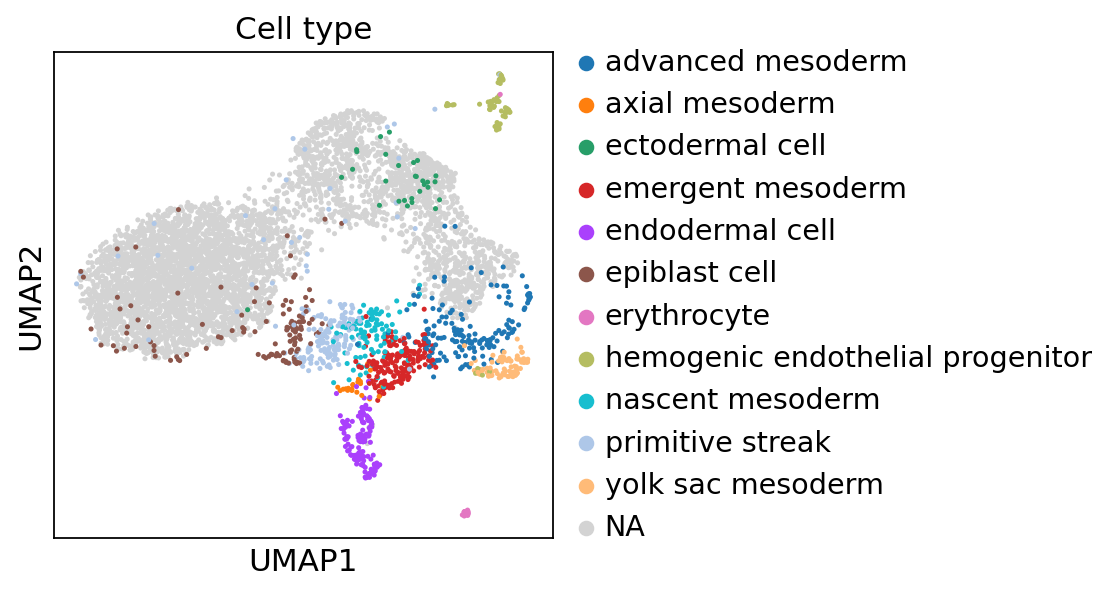

In [37]:
sc.pl.umap(dataset_samen, color=['Characteristics.inferred.cell.type...authors.labels.'], title = ["Cell type"],frameon=True, wspace=0.6)

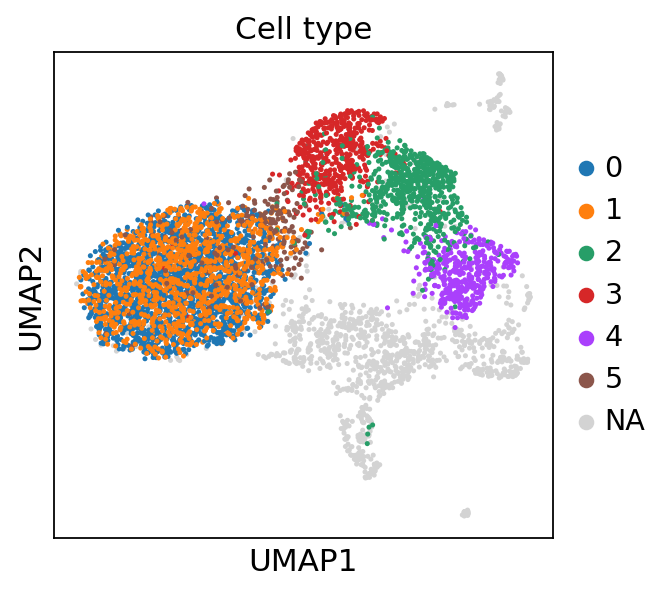

In [38]:
sc.pl.umap(dataset_samen, color=['seurat_clusters'], title = ["Cell type"],frameon=True, wspace=0.6)

Calculate directions of upregulation for each latent score and put them to kang_pbmc.uns['directions'].

In [39]:
q_intr_cvae.latent_directions(adata=dataset_samen)
q_intr_cvae.latent_enrich(groups='sample_name', comparison='rest', use_directions=True, adata=dataset_samen)


AttributeError: 'TRVAE' object has no attribute 'latent_directions'

Do gene set enrichment test for condition in reference + query using Bayes Factors.

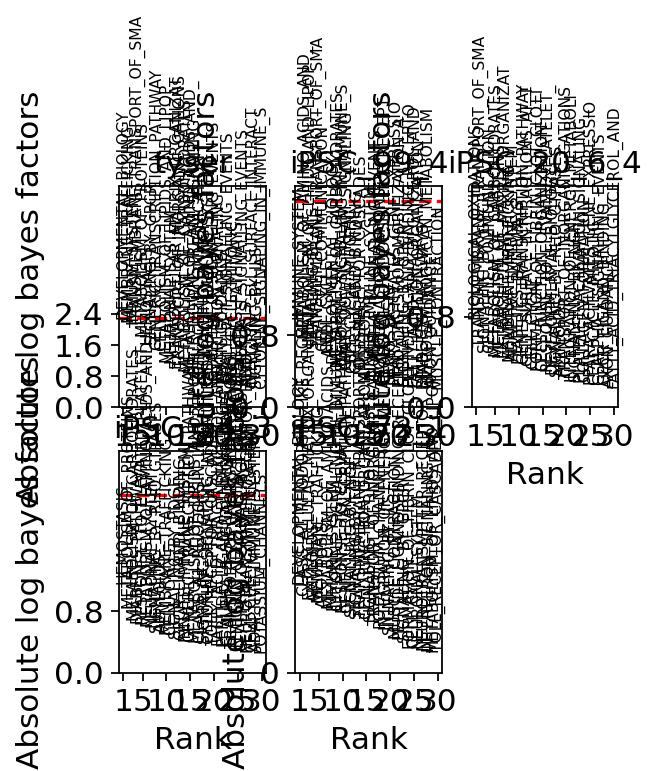

In [186]:
fig = sca.plotting.plot_abs_bfs(dataset_samen, yt_step=0.8, scale_y=2.5, fontsize=7)